In [10]:
import os
import pickle
import shutil 

import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from IPython import embed

In [11]:
# set up simulation constants

resolution = 20

n_fusedSilica = 1.44
n_PDMS = 1.4
n_amorphousSi = 3.48

a = 0.680   # lattice period 

#pml_thickness = round(wavelength / 2,3)
pml_thickness = 0.780
height_pillar = 1.020
width_PDMS = 1.560
width_fusedSilica = 0.780

cell_x = a
cell_y = a
cell_z = round(2*pml_thickness + width_PDMS + height_pillar +  width_fusedSilica, 3)

center_PDMS = round(0.5*(height_pillar + width_PDMS + pml_thickness) 
                  + (pml_thickness + width_fusedSilica) - 0.5*cell_z, 3)
center_fusedSilica = round(0.5*(pml_thickness + width_fusedSilica) - 0.5*cell_z, 3)
center_pillar = round(pml_thickness + width_fusedSilica + 0.5*height_pillar
                    - 0.5*cell_z, 3) 

z_fusedSilica = pml_thickness + width_fusedSilica
z_PDMS = height_pillar + width_PDMS + pml_thickness


In [12]:
geometry = [mp.Block(size=mp.Vector3(mp.inf,mp.inf,z_fusedSilica), 
                    center=mp.Vector3(0,0,center_fusedSilica),
                    material=mp.Medium(index=n_fusedSilica)),
            mp.Block(size=mp.Vector3(mp.inf,mp.inf,z_PDMS),
                    center=mp.Vector3(0,0,center_PDMS),
                    material=mp.Medium(index=n_PDMS))]

k_point = mp.Vector3(0,0,0)

wavelength = 1.55
freq = 1 / wavelength

## initialize matrix for data collection ##
##########################################

num = 15 # this is the number of pillars we will build
data = np.zeros((3,num))

## set up and build source ##
############################

center_source = round(pml_thickness + width_fusedSilica*0.2 - 0.5*cell_z, 3) 
source_cmpt = mp.Ey

sources = [mp.Source(mp.ContinuousSource(frequency=freq),
                    component=source_cmpt,
                    center=mp.Vector3(0,0,center_source),
                    size=mp.Vector3(cell_x,cell_y,0))]


In [13]:
## Set up simulation ##
######################

cell_size = mp.Vector3(cell_x,cell_y,cell_z)
pml_layers = [mp.PML(thickness = pml_thickness, direction = mp.Z)]

if source_cmpt == mp.Ey:
    symmetries = [mp.Mirror(mp.X, phase=+1), #epsilon has mirror symmetry in x and y, phase doesn't matter
                  mp.Mirror(mp.Y, phase=-1)] #but sources have -1 phase when reflected normal to their direction
elif src_cmpt == mp.Ex:                      #use of symmetries important here, significantly speeds up sim
    symmetries = [mp.Mirror(mp.X, phase=-1),
                  mp.Mirror(mp.Y, phase=+1)]
elif src_cmpt == mp.Ez:
    symmetries = [mp.Mirror(mp.X, phase=+1),
                  mp.Mirror(mp.Y, phase=+1)]

sim = mp.Simulation(cell_size=cell_size,
                    geometry=geometry,
                    sources=sources,
                    k_point=k_point,
                    boundary_layers=pml_layers,
                    symmetries=symmetries,
                    resolution=resolution)

nfreq = 1
df = 0
fr_center = round(0.5*cell_z - pml_thickness - 0.3*width_PDMS, 3)
fr = mp.FluxRegion(center=mp.Vector3(0,0,fr_center), 
            size=mp.Vector3(cell_x, cell_y, 0))

flux_object = sim.add_flux(freq, df, nfreq, fr)

sim.run(until=200)  # initial conditions

-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00302911 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
time for set_epsilon = 0.0532341 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)


     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)


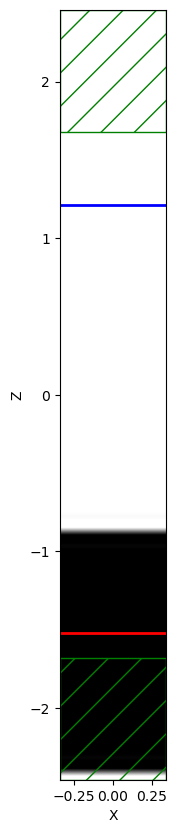

In [14]:
initial_flux = mp.get_fluxes(flux_object)[0]   

%matplotlib inline
# plot an x-z cross section
plt.close("all")
plt.figure(figsize=(10,10))
plot_plane = mp.Volume(center=mp.Vector3(0,0.0*a,0),
                            size=mp.Vector3(a,0,cell_z))
field_func = lambda x: 20*np.log10(np.abs(x))
sim.plot2D(output_plane=plot_plane
           #fields=mp.Ey
           )
plt.grid(False)
#plt.savefig("before_pillar.png")

In [15]:
initial_flux

108.17519898817523

In [6]:
sim.reset_meep()

pbar = tqdm(total=num,leave=False)
for i,radius in enumerate(np.linspace(0.075,0.25,num=num)):
    geometry.append(mp.Cylinder(radius=radius,
                        height=height_pillar,
                        axis=mp.Vector3(0,0,1),
                        center=mp.Vector3(0,0,center_pillar),
                        material=mp.Medium(index=n_amorphousSi)))

    sim = mp.Simulation(cell_size=cell_size,
                        geometry=geometry,
                        sources=sources,
                        k_point=k_point,
                        boundary_layers=pml_layers,
                        symmetries=symmetries,
                        resolution=resolution)
    
    flux_object = sim.add_flux(freq, df, nfreq, fr)  

    sim.run(until=200)
    
    res = sim.get_eigenmode_coefficients(flux_object, [1], eig_parity=mp.ODD_Y)
    coeffs = res.alpha

    flux = abs(coeffs[0,0,0]**2)
    phase = np.angle(coeffs[0,0,0]) 
    
    data[0,i] = radius
    data[1,i] = flux
    data[2,i] = phase
    if(radius!=0.25):
        sim.reset_meep()
        print(f"i= {i},radius={radius}")
        geometry.pop(-1)
    pbar.update(1)
pbar.close()


  0%|                                                                         | 0/15 [00:00<?, ?it/s]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00195217 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (0,0,-0.39)
          radius 0.075, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.0587249 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 8 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


  7%|████▎                                                            | 1/15 [00:01<00:20,  1.45s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 0,radius=0.075
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00178695 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (0,0,-0.39)
          radius 0.0875, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.0485158 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 8 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 13%|████████▋                                                        | 2/15 [00:02<00:18,  1.46s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 1,radius=0.0875
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00173903 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (0,0,-0.39)
          radius 0.1, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.046212 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 8 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 20%|█████████████                                                    | 3/15 [00:04<00:17,  1.45s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 2,radius=0.09999999999999999
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00163889 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (0,0,-0.39)
          radius 0.1125, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.0461609 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 8 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 27%|█████████████████▎                                               | 4/15 [00:05<00:16,  1.46s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 3,radius=0.11249999999999999
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00167608 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (0,0,-0.39)
          radius 0.125, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.0452111 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 8 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 33%|█████████████████████▋                                           | 5/15 [00:07<00:14,  1.46s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 4,radius=0.125
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00173998 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (0,0,-0.39)
          radius 0.1375, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.051635 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 8 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 40%|██████████████████████████                                       | 6/15 [00:08<00:13,  1.46s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 5,radius=0.13749999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00165319 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (0,0,-0.39)
          radius 0.15, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.0511041 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 8 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 47%|██████████████████████████████▎                                  | 7/15 [00:10<00:11,  1.46s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 6,radius=0.15
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00163388 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (0,0,-0.39)
          radius 0.1625, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.04688 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 8 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 53%|██████████████████████████████████▋                              | 8/15 [00:11<00:10,  1.46s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 7,radius=0.16249999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00167894 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (0,0,-0.39)
          radius 0.175, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.049737 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 8 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 60%|███████████████████████████████████████                          | 9/15 [00:13<00:08,  1.46s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 8,radius=0.175
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00156689 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (0,0,-0.39)
          radius 0.1875, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.0546281 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 8 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 67%|██████████████████████████████████████████▋                     | 10/15 [00:14<00:07,  1.46s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 9,radius=0.1875
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00163198 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (0,0,-0.39)
          radius 0.2, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.0519712 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 8 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 73%|██████████████████████████████████████████████▉                 | 11/15 [00:16<00:05,  1.47s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 10,radius=0.19999999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.001616 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (0,0,-0.39)
          radius 0.2125, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.052175 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 8 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 80%|███████████████████████████████████████████████████▏            | 12/15 [00:17<00:04,  1.47s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 11,radius=0.21249999999999997
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00163293 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (0,0,-0.39)
          radius 0.225, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.05074 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 8 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 87%|███████████████████████████████████████████████████████▍        | 13/15 [00:19<00:02,  1.47s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 12,radius=0.22499999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00159311 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (0,0,-0.39)
          radius 0.2375, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.0558681 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 8 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 93%|███████████████████████████████████████████████████████████▋    | 14/15 [00:20<00:01,  1.47s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


i= 13,radius=0.2375
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00159788 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (0,0,-0.39)
          radius 0.25, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.0542428 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 8 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (0,0,-0.39)
          radius 0.25, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)


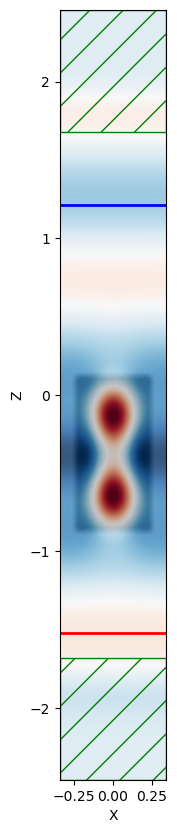

In [8]:
# plot an x-z cross section
plt.close("all")
plt.figure(figsize=(10,10))
plot_plane = mp.Volume(center=mp.Vector3(0,0.0*a,0),
                            size=mp.Vector3(a,0,cell_z))
field_func = lambda x: 20*np.log10(np.abs(x))
sim.plot2D(output_plane=plot_plane
           #fields=mp.Ey
           )
plt.grid(False)

/tmp/ipykernel_588/2074998849.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


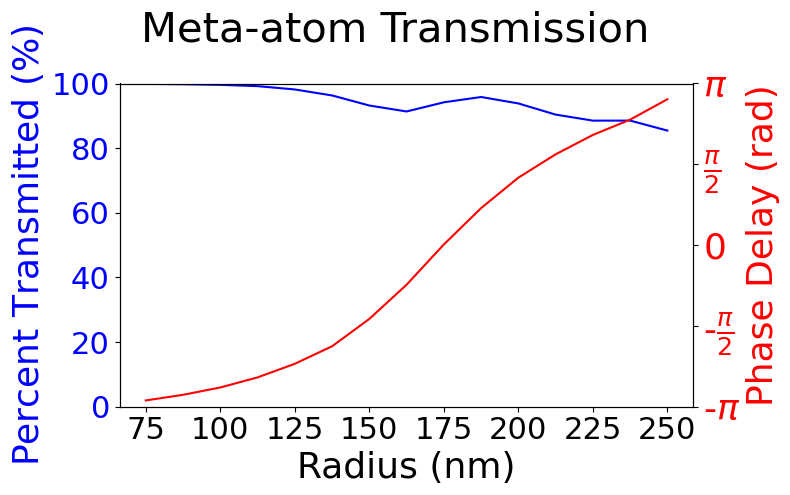

In [9]:
### plot transmission and phase as a function of pillar radius ###
plt.close("all")

radii = data[0,:]
flux_list = data[1,0:] / initial_flux
phase_list = data[2,0:]

plt.style.use('seaborn-colorblind')

tickfontsize=22
labelfontsize=26
titlefontsize=30

fig,ax = plt.subplots(figsize=(8,5)) # may want to change. Also see DPI keyword

fig.suptitle("Meta-atom Transmission",fontsize=titlefontsize)

ax.set_xlabel("Radius (nm)",fontsize=labelfontsize)
ax.set_xticks([0.075,0.100,0.125,0.150,0.175,0.200,0.225,0.250])
ax.set_xticklabels([75,100,125,150,175,200,225,250],fontsize=tickfontsize)
ax.set_ylim([0,1])
ax.set_ylabel(r'Percent Transmitted ($\%$)',fontsize=labelfontsize, color = 'blue')
ax.plot(radii,flux_list,'b',label='Transmission')
ax.tick_params(axis='y', labelcolor = 'blue')

ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0, 20,40,60,80,100],fontsize=tickfontsize)

twin1 = ax.twinx()
twin1.set_ylim([-np.pi,np.pi])
twin1.set_ylabel(r'Phase Delay (rad)',fontsize=labelfontsize, color = 'red')
twin1.set_yticks([-np.pi, -(0.5*np.pi),0, np.pi / 2, np.pi])
twin1.set_yticklabels([r'-$\pi$',r'-$\frac{\pi}{2}$',r'0',r'$\frac{\pi}{2}$',r'$\pi$'],fontsize=tickfontsize+4)
twin1.plot(radii,phase_list,'r',label='Phase')
twin1.tick_params(axis='y', labelcolor = 'red')

plt.grid(False)
plt.tight_layout()